# Convolutional Neural Network Step by Step:

## 1. Packages

In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# to see matplotlib plots directly inside this nb.
%matplotlib inline 
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['image.interpolation'] = 'nearest' # Disables image smoothing (show raw pixels)
plt.rcParams['image.cmap'] = 'gray'

# automatic module reloading.
%load_ext autoreload 
# reloads all imported modules before executing any code cell
%autoreload 2 

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ouline:
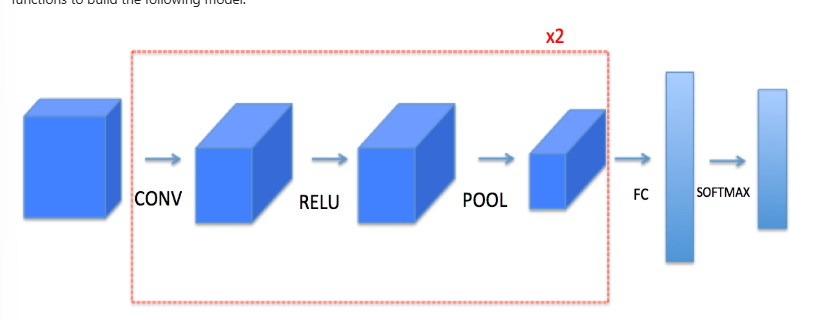

## 3. CNN

### 3.1 Zero-Padding:

In [7]:
def zero_pad(X, pad): # padding with zeros
    """
        X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
        pad -- integer, amount of padding around each image on vertical and horizontal dimensions
        
        Returns:
        X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    x_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    return x_pad


x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


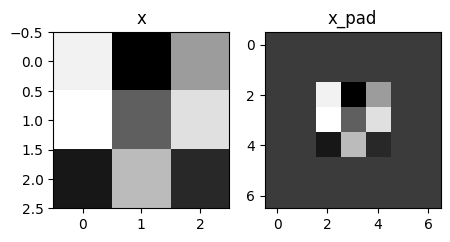

In [8]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2) # with 2 0's on each side
print("x.shape =", x.shape)
print("x_pad.shape =", x_pad.shape)
print("x[1,1] =", x[1,1])
print("x_pad[1,1] =", x_pad[1,1])

fig, ax = plt.subplots(1, 2)
ax[0].set_title('x')
ax[0].imshow(x[0,:,:,0])
ax[1].set_title('x_pad')
ax[1].imshow(x_pad[0,:,:,0])

### 3.2 Single Step of convolution

In [9]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    z = np.sum(s)
    z = z + float(b)
    return z

In [10]:
np.random.seed(1)  # to follow the same series of random numbers
a_slic_prev = np.random.randn(4, 4, 3)
w = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
z = conv_single_step(a_slic_prev, w, b)
print("z =", z )

z = -6.999089450680221


C:\Users\Naman chanana\AppData\Local\Temp\ipykernel_8440\4055568752.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = z + float(b)


### 3.3 Convolutional Neural Network - Forward Pass

In [11]:
def conv_forward(a_prev, W, b, hparams):
    (m, n_H_prev, n_W_prev, n_C_prev) = a_prev.shape
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparams['stride']
    pad = hparams['pad']

    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1 # to floor the values int() is used
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    z = np.zeros((m, n_H, n_W, n_C)) # initialize output volume Z with zeros
    a_prev_pad = zero_pad(a_prev, pad)

    for i in range(m): # over the batch
        a_prev_pad_i = a_prev_pad[i, :, :, :] # ith training example
        for h in range(n_H): # over vertical axis
            #  vertical start and end of the slice of 1 example matrics (image)
            vert_start = h * stride
            vert_end = vert_start + f

            for w in range(n_W): # over horizontal axis
                horiz_start = w * stride
                horiz_end = horiz_start + f

                # now loop over channels
                for c in range(n_C):
                    a_slice_prev = a_prev_pad_i[vert_start:vert_end, horiz_start:horiz_end, :] # slice of input data

                    # now convolve with the correct filter W and bias b to get one output neuron
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    assert(z.shape == (m, n_H, n_W, n_C))
    cache = (a_prev, W, b, hparams)
    return z, cache







In [13]:
np.random.seed(1)
A_prev = np.random.randn(10, 5, 7, 4)
w = np.random.randn(3, 3, 4, 8 ) # as 4 channels in input and 8 filters
b = np.random.randn(1, 1, 1, 8)
hparams = {"pad" : 1, "stride": 2}
Z, cache_conv = conv_forward(A_prev, w, b, hparams)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.6923608807576933
Z[3,2,1] = [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]


C:\Users\Naman chanana\AppData\Local\Temp\ipykernel_8440\4055568752.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = z + float(b)


## 4. Pooling Layer:

### 4.1 Forward Pooling:

In [17]:
def pool_forward(a_prev, hparams, mode='max'):
    (m, n_h_prev, n_w_prev, n_C_prev) = a_prev.shape # retrieve dimensions

    f = hparams['f']
    stride = hparams['stride']

    # define the dims of output matrix A
    n_h = int(1 + (n_h_prev - f)/ stride)
    n_w = int(1 + (n_w_prev - f)/ stride)
    n_c = n_C_prev

    A = np.zeros((m, n_h, n_w, n_c)) # initialize output matrix A

    for i in range(m): # loop over training examples
        for h in range(n_h):
            vert_start = h * stride
            vert_end = h*stride + f

            for w in range(n_w):
                horiz_start = w*stride
                horiz_end = w*stride+f

                for c in range(n_c): # loop over channels
                    a_prev_slice = a_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (a_prev, hparams) # for backpropagation
    assert(A.shape == (m, n_h, n_w, n_c))
    return A, cache




In [19]:
# for stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparams = {"f": 3, "stride": 1}

A, cache = pool_forward(A_prev, hparams)
print("mode = max")
print("A.shape = ", str(A.shape))
print("A = \n", A)
print()
A, cache = pool_forward(A_prev, hparams, mode='average')
print("mode = average")
print("A.shape = ", str(A.shape))

print("A = \n", A)

mode = max
A.shape =  (2, 3, 3, 3)
A = 
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape =  (2, 3, 3, 3)
A = 
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]


In [20]:
# for stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


## 5. Backpropagation in convolutional neural networks:

### 5.1 Convolutional layer backward pass

#### 5.1.1 Computing dA:
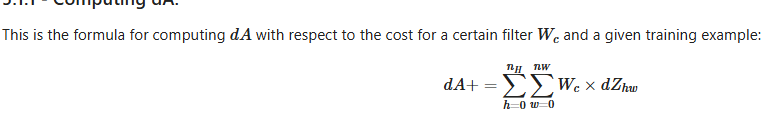

#### 5.1.2 Computing dW:
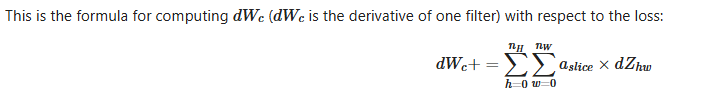

#### 5.1.3 Computing db:
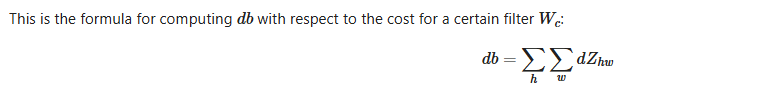

In [27]:
def conv_backward(dZ, cache):
    (a_prev, W, b, hparams) = cache # from cache
    (m, n_h_prev, n_w_prev, n_c_prev) = a_prev.shape # dims from a_Prev's shape
    (f, f, n_c_prev, n_c) = W.shape # dims from W's shape

    stride = hparams['stride']
    pad = hparams['pad']

    (m, n_h, n_w, n_c) = dZ.shape # dims from dZ's shape

    da_prev = np.zeros_like(a_prev)
    dw = np.zeros_like(W)
    db = np.zeros_like(b)

    a_prev_pad = zero_pad(a_prev, pad)
    da_prev_pad = zero_pad(da_prev, pad)

    for i in range(m):
        a_prev_pad_i = a_prev_pad[i, :, :, :]
        da_prev_pad_i = da_prev_pad[i, :, :, :]

        for h in range(n_h):
            vert_start = h*stride
            vert_end = h*stride + f

            for w in range(n_w):
                horiz_start = w*stride
                horiz_end = w*stride + f

                for c in range(n_c):
                    a_slice = a_prev_pad_i[vert_start:vert_end, horiz_start:horiz_end, :]

                    # update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad_i[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c]* dZ[i, h, w, c]
                    dw[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]

        # Set the ith training example's dA_prev to the unpadded da_prev_pad_i
        da_prev[i, :, :, :] = da_prev_pad_i[pad:-pad, pad:-pad, :] if pad != 0 else da_prev_pad_i

    assert(da_prev.shape == (m, n_h_prev, n_w_prev, n_c_prev))
    return da_prev, dw, db

In [25]:
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)


C:\Users\Naman chanana\AppData\Local\Temp\ipykernel_8440\4055568752.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = z + float(b)


In [28]:
# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


### 5.2 Pooling Layer - backward pass.

#### 5.2.1 Max pooling - backward pass.
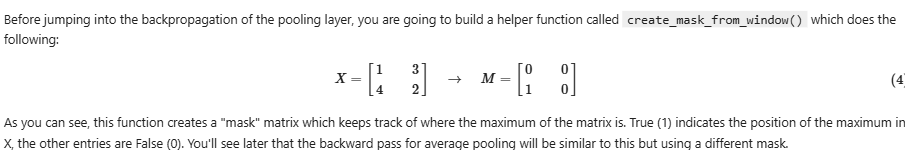

In [29]:
def create_mask_from_window(x):
    mask = (x == np.max(x))
    return mask

In [30]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


#### 5.2.2 Average pooling - backward pass
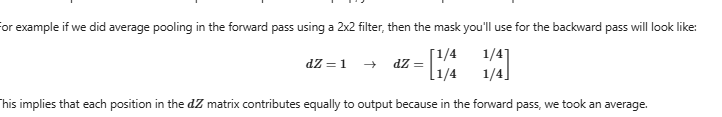

In [31]:
def distribute_value(dz, shape):
    (n_h, n_w) = shape
    average = dz / (n_h * n_w)
    a = np.ones((n_h, n_w)) * average
    return a

In [32]:
a = distribute_value(2, (2,2))
print('distributed value = ', a)

distributed value =  [[0.5 0.5]
 [0.5 0.5]]


#### 5.2.3 Putting it together: Pooling backward.

In [39]:
def pool_backward(da, cache, mode = "max"):
    (a_prev, hparams) = cache
    stride = hparams['stride']
    f = hparams['f']

    m, n_h_prev, n_w_prev, n_c_prev = a_prev.shape
    m, n_h, n_w, n_C = da.shape
    da_prev = np.zeros_like(a_prev)

    for i in range(m):
        a_prev_i = a_prev[i, :, :, :]
        for h in range(n_h):
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_w):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):
                    if mode == "max":
                        a_prev_slice = a_prev_i[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        da_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * da[i, h, w, c]
                    elif mode == "average":
                        da_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da[i, h, w, c], (f, f))

    assert(da_prev.shape == a_prev.shape)
    return da_prev

In [40]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


End.